In [1]:
# Setup  Chunk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import gensim.parsing.preprocessing
from gensim.parsing.preprocessing import strip_punctuation, strip_tags, strip_numeric
from nltk.stem.wordnet import WordNetLemmatizer   
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess


import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import time


# NLTK Stop words extended
stop_words = stopwords.words('english')
lemma = WordNetLemmatizer()

from sklearn.utils import shuffle

import spacy
import gensim
import gensim.corpora as corpora


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\31202\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\31202\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Steps of Topic Modeling

- Loading data
- Data Cleaning (Phrase Modeling: Bi-grams and Tri-grams)
- Data transformation: Corpus and Dictionary
- Base Model Performance
- Hyperparameter Tuning 
- Final Model
- Visualize Results


### Loading the dataset

In [2]:
df = pd.read_csv("C:\\Users\\31202\\Desktop\\Wiki.csv") #Dataset is scrapped from wikipedia


Dataset is scraped from wikipedia and & can be classified into following four categories

1: Cricket

2: Movies

3: AI & ML

4: Health

In [3]:
df = shuffle(df) #randomly shuffle all rows
df.head()

,Text,Category
984,"Information technology, together with industri...",3
1262,Surgery is an ancient medical specialty that u...,4
1290,The major shift in medical thinking was the gr...,4
374,"Historically, the ""Oscarcast"" has pulled in a ...",2
766,"In computer science, Artificial intelligence (...",3


In [4]:
df.shape # dimensions of the dataset

(1355, 2)

### Data Cleaning

In [5]:
# bigram_mod = gensim.models.phrases.Phraser(bigram) # Automatically detect common phrases
# trigram_mod = gensim.models.phrases.Phraser(trigram)


# Function to clean text
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [6]:
t1 = time.time()
corpus1 = process_words(df['Text'])  # corpus cleaned of html tags, puncs, lemmas
t2 = time.time()
print(t2-t1,"Secs")

11.464969158172607 Secs


### Data Transformation: Corpus and Dictionary

In [7]:
## DTM building etc via gensim
corpus2 = [[word for word in ' '.join(doc).split()] for doc in corpus1]  # word_tokenize first
id2word = corpora.Dictionary(corpus2)  # Create Dictionary
corpus = [id2word.doc2bow(text) for text in corpus2]  # Building gensim corpus. TF DTM creation.
print(corpus[:1])  # View one doc in abstract form

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

### Base Model

In [8]:
%%time
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


Wall time: 8.72 s


In [9]:
from pprint import pprint
pprint(lda_model.print_topics())


[(0,
  '0.024*"internet" + 0.015*"also" + 0.015*"use" + 0.014*"include" + '
  '0.013*"many" + 0.013*"field" + 0.012*"advertising" + 0.011*"network" + '
  '0.010*"call" + 0.009*"allow"'),
 (1,
  '0.017*"health" + 0.014*"include" + 0.010*"medical" + 0.009*"disease" + '
  '0.009*"hospital" + 0.008*"medicine" + 0.008*"often" + 0.008*"also" + '
  '0.008*"many" + 0.007*"person"'),
 (2,
  '0.033*"use" + 0.012*"human" + 0.012*"system" + 0.011*"computer" + '
  '0.010*"technology" + 0.010*"base" + 0.009*"example" + 0.008*"control" + '
  '0.008*"knowledge" + 0.008*"ai"'),
 (3,
  '0.034*"film" + 0.017*"first" + 0.013*"studio" + 0.011*"match" + '
  '0.010*"year" + 0.009*"international" + 0.009*"make" + 0.009*"play" + '
  '0.009*"team" + 0.008*"movie"')]


#### What is the Dominant topic and its percentage contribution in each document

In [10]:
sent_topics_df = pd.DataFrame()
  # Get main topic in each document
for i, row_list in enumerate(lda_model[corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list  
      
  # print(row)
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
  # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:# => dominant topic
            wp = lda_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
            break
sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']


In [11]:
sent_topics_df.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,2.0,0.7893,"use, human, system, computer, technology, base..."
1,1.0,0.8557,"health, include, medical, disease, hospital, m..."
2,2.0,0.5134,"use, human, system, computer, technology, base..."
3,3.0,0.7881,"film, first, studio, match, year, internationa..."
4,2.0,0.7091,"use, human, system, computer, technology, base..."


#### Word Clouds of Top N Keywords in Each Topic 

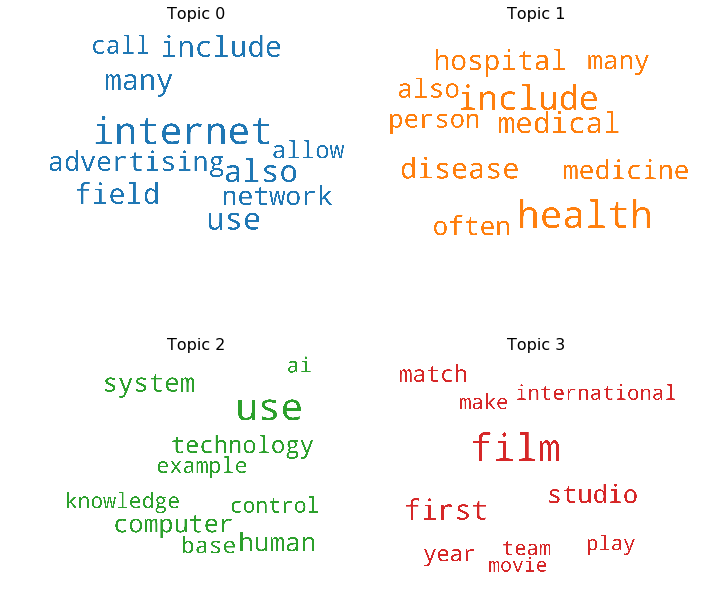

In [12]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Compute Model Perplexity & Coherence Score

Let's calculate baseline score

In [13]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus1, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.37145048377375545


### Visualize topics

In [14]:
%%time
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
# pyLDAvis.save_html(vis, 'lda.html') # for saving visuaization
vis
# pyLDAvis.display(vis) # for colab

Wall time: 2min 46s


C:\Users\31202\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.281310  0.098138       1        1  32.383709
2     -0.192153  0.206160       2        1  26.945633
1     -0.055477 -0.080663       3        1  21.339930
0     -0.033680 -0.223635       4        1  19.330734, topic_info=    Category        Freq      Term       Total  loglift  logprob
218  Default  569.000000      film  569.000000  30.0000  30.0000
24   Default  606.000000       use  606.000000  29.0000  29.0000
546  Default  242.000000  internet  242.000000  28.0000  28.0000
334  Default  281.000000     first  281.000000  27.0000  27.0000
295  Default  190.000000    health  190.000000  26.0000  26.0000
..       ...         ...       ...         ...      ...      ...
50    Topic4  136.978668   include  305.209900   0.8423  -4.2920
24    Topic4  150.711517       use  606.162842   0.2517  -4.1965
332   Topic4   46.027893     exist   50.209774   1.5565  -5.3826
576   Topic4   50.866837   provide   67.601196   1.3591  -5.2826
145   Topic4   50.899071   however  109.875595   0.8740  -5.2820

[193 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1049      4  0.991784       access
3764      1  0.016538  advertising
3764      2  0.008269  advertising
3764      3  0.008269  advertising
3764      4  0.967454  advertising
...     ...       ...          ...
272       3  0.993318         well
570       2  0.987339         word
273       3  0.983867         work
160       1  0.782689         year
160       3  0.213040         year

[205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])